In [6]:
# Initialize Otter
import otter
grader = otter.Notebook("proj03.ipynb")

<table style="width: 100%;">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Spring 2020<br>
            Dr. Eric Van Dusen<br>
            Notebook by Chris Pyles</p></td></tr>
</table>

# Project 3: Econometrics and Data Science

This project focuses on the application of the data science techniques from lecture. You will practice single variable ordinary least squares regression in the Data 8 style, go through a guided introduction to multivariate OLS using the package `statsmodels`, and finally create your own multivariate OLS model.

After this project, you should be able to

1. Write and apply the necesssary functions to perform single variable OLS
2. Use the `statsmodels` package to create multivariate OLS models
3. Understand how to quantitatively evaluate models using the root-mean-squared error
4. Look for and use relationships between variables to select features for regression

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import warnings

from ipywidgets import interact, Dropdown, IntSlider

warnings.simplefilter(action='ignore')
%matplotlib inline
plt.style.use('seaborn-muted')
plt.rcParams["figure.figsize"] = [10,7]

In this project, we will be working with data on credit card defaults and billing. The data covers April to September 2005, with one row for each cardholder. It has the following columns:

| Column | Description |
|-----|-----|
| `credit` | Total amount of credit |
| `sex` | Cardholder sex |
| `education` | Cardholder education level |
| `martial_status` | Cardholder marital status |
| `age` | Cardholder age |
| `bill_{month}05` | Bill amount for specific month |
| `paid_{month}05` | Amount paid in specified month |
| `default` | Whether the cardholder defaulted |

In the cell below, we load the dataset.

In [8]:
defaults = pd.read_csv("defaults.csv")
defaults

credit     sex      education marital_status  age  bill_sep05  \
0       20000  female  undergraduate        married   24        3913   
1      120000  female  undergraduate         single   26        2682   
2       90000  female  undergraduate         single   34       29239   
3       50000  female  undergraduate        married   37       46990   
4       50000    male  undergraduate        married   57        8617   
...       ...     ...            ...            ...  ...         ...   
29995  220000    male        diploma        married   39      188948   
29996  150000    male        diploma         single   43        1683   
29997   30000    male  undergraduate         single   37        3565   
29998   80000    male        diploma        married   41       -1645   
29999   50000    male  undergraduate        married   46       47929   

       bill_aug05  bill_jul05  bill_jun05  bill_may05  bill_apr05  paid_sep05  \
0            3102         689           0           0           0           0   
1            1725        2682        3272        3455        3261           0   
2           14027       13559       14331       14948       15549        1518   
3           48233       49291       28314       28959       29547        2000   
4            5670       35835       20940       19146       19131        2000   
...           ...         ...         ...         ...         ...         ...   
29995      192815      208365       88004       31237       15980        8500   
29996        1828        3502        8979        5190           0        1837   
29997        3356        2758       20878       20582       19357           0   
29998       78379       76304       52774       11855       48944       85900   
29999       48905       49764       36535       32428       15313        2078   

       paid_aug05  paid_jul05  paid_jun05  paid_may05  paid_apr05  default  
0             689           0           0           0           0        1  
1            1000        1000        1000           0        2000        1  
2            1500        1000        1000        1000        5000        0  
3            2019        1200        1100        1069        1000        0  
4           36681       10000        9000         689         679        0  
...           ...         ...         ...         ...         ...      ...  
29995       20000        5003        3047        5000        1000        0  
29996        3526        8998         129           0           0        0  
29997           0       22000        4200        2000        3100        1  
29998        3409        1178        1926       52964        1804        1  
29999        1800        1430        1000        1000        1000        1  

[30000 rows x 18 columns]

**Question 0.1:** Which of the columns in `defaults` would we need dummies for in order to use in an OLS model? Assign `q0_1` to an list of these column _labels_.

In [9]:
q0_1 = ["sex", "education", "marital_status"] # SOLUTION
q0_1

['sex', 'education', 'marital_status']

In [10]:
grader.check("q0_1")

q0_1 results: All test cases passed!

In order to use the columns you chose, we will need to create dummies for them. In lecture, we showed a function (defined in the imports cell) that will get dummies for a variable for you.

**Question 0.2:** Use `pd.get_dummies` to get dummies for the variables you listed in `q0_1`.

In [11]:
defaults = pd.get_dummies(defaults, columns=q0_1) # SOLUTION

In [12]:
grader.check("q0_2")

q0_2 results: All test cases passed!

## Part 1: Single Variable OLS

We'll start by doing some single variable linear regression, ala Data 8. To begin, recall that we can model $y$ based on $x$ using the form

$$\Large
\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x
$$

We can define the **correlation coefficient** of two values to be the mean of the product of their values in standard units.

**Question 1.1:** Complete the `corr` function below to compute the correlation coefficient of two arrays `x` and `y` based on the formula

$$\Large
r = \text{mean} \left ( x_\text{SU} \cdot y_\text{SU} \right )
$$

_Hint:_ You may find the `su` function, which converts an array to standard units, helpful.

In [13]:
def su(arr):
    """Converts array arr to standard units"""
    return (arr - np.mean(arr)) / np.std(arr)

def corr(x, y):
    """Calculates the correlation coefficient of two arrays"""
    return np.mean(su(x) * su(y)) # SOLUTION

In [14]:
grader.check("q1_1")

q1_1 results: All test cases passed!

From this $r$ value that we have calculated above, we can compute the slope $\beta_1$ and intercept $\beta_0$ of the best-fit line using the formulas below.

$$\Large
\beta_1 = r \frac{\hat{\sigma}_y}{\hat{\sigma}_x}
\qquad \text{ and } \qquad
\beta_0 = \hat{\mu}_y - \beta_1 \cdot \hat{\mu}_x
$$

**Question 1.2:** Using your `corr` function, fill in the `slope` and `intercept` functions below which compute the values of $\beta_1$ and $\beta_0$ for the line of best fit that predicts `y` based on `x`. Your function should use vectorized arithmetic (i.e. no `for` loops).

_Hint:_ You may find your `slope` function useful in `intercept`.

In [101]:
def slope(x, y):
    """Computes the slope of the best-fit line of y based on x"""
    return np.std(y) * corr(x, y) / np.std(x) # SOLUTION

def intercept(x, y):
    """Computes the intercept of the best-fit line of y based on x"""
    return np.mean(y) - slope(x, y) * np.mean(x) # SOLUTION

In [102]:
grader.check("q1_2")

q1_2 results: All test cases passed!

Now let's look at how we can predict the `bill_sep05` column based on some other column of our data. We'll start by looking at the `credit` as the explanatory variable. To use our functions above, we must extract the values of each column as arrays, which we define below as `x` and `y`. We then compute the fitted values `y_hat` using the slope-intercept formula and plot the results.

**Question 1.3:** Using the functions you defined in Question 1.2, regress `bill_sep05` on `credit`. Assign your predictions to `y_hat`.

In [74]:
x = defaults["credit"]
y = defaults["bill_sep05"]

beta_1 = slope(x, y)           # SOLUTION
beta_0 = intercept(x, y)       # SOLUTION
y_hat = beta_1 * x + beta_0    # SOLUTION

In [75]:
grader.check("q1_3")

q1_3 results:
    q1_3 - 1 result:
        ❌ Test case failed
        Trying:
            assert len(y_hat) == len(y)
        Expecting nothing
        ok
        Trying:
            assert x.shape == (30000,)
        Expecting nothing
        ok
        Trying:
            assert 0.1 <= beta_1 <= 0.2
        Expecting nothing
        ok
        Trying:
            assert 23000 <= beta_0 <= 25000
        Expecting nothing
        **********************************************************************
        Line 4, in q1_3 0
        Failed example:
            assert 23000 <= beta_0 <= 25000
        Exception raised:
            Traceback (most recent call last):
              File "/Users/chrispyles/opt/miniconda3/lib/python3.7/doctest.py", line 1330, in __run
                compileflags, 1), test.globs)
              File "<doctest q1_3 0[3]>", line 1, in <module>
                assert 23000 <= beta_0 <= 25000
            AssertionError

    q1_3 - 2 result:
        ✅ Test case passed

    q1_3 - 3 result:
        ❌ Test case failed
        Trying:
            assert np.isclose(beta_0, 24092.480872897704)
        Expecting nothing
        **********************************************************************
        Line 1, in q1_3 2
        Failed example:
            assert np.isclose(beta_0, 24092.480872897704)
        Exception raised:
            Traceback (most recent call last):
              File "/Users/chrispyles/opt/miniconda3/lib/python3.7/doctest.py", line 1330, in __run
                compileflags, 1), test.globs)
              File "<doctest q1_3 2[0]>", line 1, in <module>
                assert np.isclose(beta_0, 24092.480872897704)
            AssertionError

    q1_3 - 4 result:
        ❌ Test case failed
        Trying:
            np.random.seed(1001)
        Expecting nothing
        ok
        Trying:
            sub_y = np.random.choice(y_hat, 5)
        Expecting nothing
        ok
        Trying:
            assert np.allclose(sub_y, [105087.67372178, 40291.51944267, 27332.28858685, 27332.28858685, 27332.28858685])
        Expecting nothing
        **********************************************************************
        Line 3, in q1_3 3
        Failed example:
            assert np.allclose(sub_y, [105087.67372178, 40291.51944267, 27332.28858685, 27332.28858685, 27332.28858685])
        Exception raised:
            Traceback (most recent call last):
              File "/Users/chrispyles/opt/miniconda3/lib/python3.7/doctest.py", line 1330, in __run
                compileflags, 1), test.globs)
              File "<doctest q1_3 3[2]>", line 1, in <module>
                assert np.allclose(sub_y, [105087.67372178, 40291.51944267, 27332.28858685, 27332.28858685, 27332.28858685])
            AssertionError

Now that we have some predictions, let's plot the original data and the regression line.

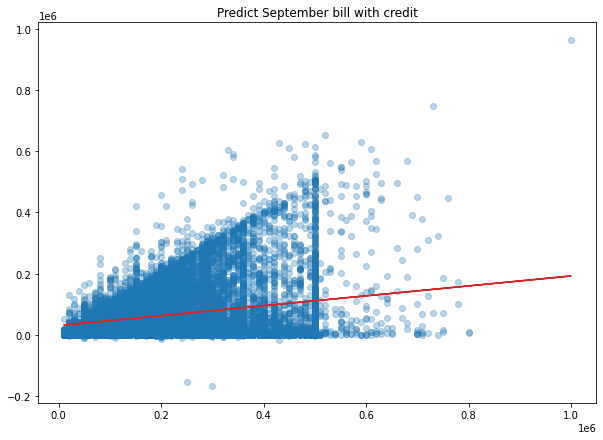

In [76]:
plt.scatter(x, y, color="tab:blue", alpha=0.3)
plt.plot(x, y_hat, color="tab:red")
plt.title("Predict September bill with credit");

<!-- BEGIN QUESTION -->

**Question 1.4:** Does the line we found fit the data well? Explain.

_Type your answer here, replacing this text._

<div class="alert alert-danger">

<strong>SOLUTION:</strong> Nope
    
</div>

<!-- END QUESTION -->

Let's estimate how confident we are in the significance of our $\hat{\beta}_1$ coefficient.

**Question 1.5:** Fill in the code below to bootstrap our $\hat{\beta}_1$ and find the 95% confidence interval. Store the lower and upper bounds as `ci95_lower` and `ci95_upper`, respectively. (The cell may take a couple minutes to run.)

_Hint:_ Since we're only interested in $\hat{\beta}_1$, we don't need to find the intercept or fit our $x$ values.

In [77]:
np.random.seed(42)                                           # SEED
betas = []

for i in np.arange(200):
    sample = defaults.sample(5000)    # defaults is a huge table, so we'll only sample 5000 rows
    sample_x = sample["credit"]                              # SOLUTION
    sample_y = sample["bill_sep05"]                          # SOLUTION
    betas.append(slope(sample_x, sample_y))                  # SOLUTION

ci95_lower = np.percentile(betas, 2.5)                          # SOLUTION
ci95_upper = np.percentile(betas, 97.5)                         # SOLUTION

print("95% CI: ({}, {})".format(ci95_lower, ci95_upper))

95% CI: (0.14428934823150433, 0.1863526283850078)


In [78]:
grader.check("q1_5")

q1_5 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 1.6:** Using your 95% confidence interval, is it likely that the credit has no effect on the September 2005 bill? Justify your answer.

_Type your answer here, replacing this text._

<div class="alert alert-danger">

<strong>SOLUTION:</strong> No, the CI does not contain 0.
    
</div>

<!-- END QUESTION -->

Obviously, we can see that our best-fit line does not predict perfectly. There are plenty of points in the scatterplot that do not fall on the line. But how do we quantify the error of our model? There are many so-called *loss functions*, but in this notebook we will use the **root-mean-squared error**, which is defined as

$$\Large
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left ( y_i - \hat{y}_i \right ) ^2 }
$$

where $n$ is the number of observations. The effect of this is to take the mean of the distance of each value of $\hat{y}$ from its corresponding value in $y$; squaring these values keeps them positive, and then we take the square root to correct the units of the error.

**Question 1.7:** Complete the function `rmse` below which computes the root-mean-squared error of the prediction `y_hat` on `y`. Again, no `for` loops.

In [79]:
def rmse(y, y_hat):
    """Computes the RMSE of prediction y_hat based on y"""
    return np.sqrt(np.mean((y - y_hat)**2)) # SOLUTION

In [80]:
grader.check("q1_7")

q1_7 results: All test cases passed!

**Question 1.8:** Use your `rmse` function to compute the RMSE of our prediction `y_hat` based on `y` from above.

In [81]:
single_var_error = rmse(y, y_hat) # SOLUTION
single_var_error

70835.69503989551

In [82]:
grader.check("q1_8")

q1_8 results:
    q1_8 - 1 result:
        ✅ Test case passed

    q1_8 - 2 result:
        ❌ Test case failed
        Trying:
            assert np.isclose(single_var_error, 70571.40305975602)
        Expecting nothing
        **********************************************************************
        Line 1, in q1_8 1
        Failed example:
            assert np.isclose(single_var_error, 70571.40305975602)
        Exception raised:
            Traceback (most recent call last):
              File "/Users/chrispyles/opt/miniconda3/lib/python3.7/doctest.py", line 1330, in __run
                compileflags, 1), test.globs)
              File "<doctest q1_8 1[0]>", line 1, in <module>
                assert np.isclose(single_var_error, 70571.40305975602)
            AssertionError

Now that we know how to predict based on and quantify the error of a model, let's write a function that will encapsulate this pipeline for us.

<!-- BEGIN QUESTION -->

**Question 1.9:** Fill in the function `pred_and_plot` below which models `bill_sep05` based on a column `col`, plots the scatterplot and line of best fit, and computes the RMSE of the model. Then choose a column you think might be related to `bill_sep05` and use your `pred_and_plot` function to determine its prediction RMSE and plot the regression line.

_Hint:_ Your code from Question 1.3 may be helpful here...

RMSE: 73039.32647


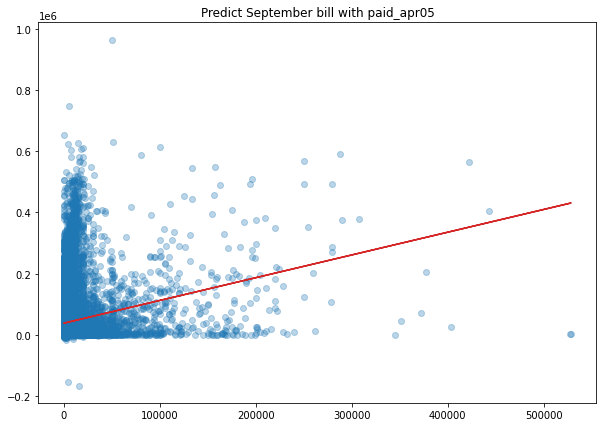

In [83]:
def pred_and_plot(col):
    """Performs single variable OLS to predict bill_sep05 based on col"""
    x = defaults[col]                  # SOLUTION
    y = defaults["bill_sep05"]         # SOLUTION

    beta_1 = slope(x, y)               # SOLUTION
    beta_0 = intercept(x, y)           # SOLUTION

    y_hat = beta_1 * x + beta_0        # SOLUTION
    
    model_rmse = rmse(y, y_hat)        # SOLUTION
    
    
    ### DO NOT EDIT THE REST OF THIS FUNCTION ###
    print("RMSE: {:.5f}".format(rmse(y, y_hat)))

    plt.scatter(x, y, color="tab:blue", alpha=0.3)
    plt.plot(x, y_hat, color="tab:red")
    plt.title("Predict September bill with {}".format(col))

""" # BEGIN PROMPT
### Provide your column name below ###
pred_and_plot(...)
""" # END PROMPT
pred_and_plot("paid_apr05")  # SOLUTION NO PROMPT)

<!-- END QUESTION -->

In looking through different features, you should have noticed that most of them don't follow a linear relationship very well. In practice, you often need _multiple_ features (explanatory variables) to predict an outcome variable, and it is for this reason that we often use **multiple linear regression** to predict variables.

Finally, before moving on to the multivariable case, let's think about using whether or not an individual defaults as a predictor of their September 2005 bill.

**Question 1.10:** Assign `default_beta_1` and `default_beta_0` to the slope and intercept of your regression of `bill_sep05` on the `default` column of the table `defaults`.

_Hint:_ Our outcome variable hasn't changed, so we can reuse the array `y` defined earlier.

In [84]:
default_x = defaults["default"]               # SOLUTION

default_beta_1 = slope(default_x, y)          # SOLUTION
default_beta_0 = intercept(default_x, y)      # SOLUTION

print("y_hat = {} * x + {}".format(default_beta_1, default_beta_0))

y_hat = -3485.0649761630766 * x + 52669.82415313287


In [85]:
grader.check("q1_10")

q1_10 results:
    q1_10 - 1 result:
        ✅ Test case passed

    q1_10 - 2 result:
        ❌ Test case failed
        Trying:
            assert 51000 <= default_beta_0 <= 52000
        Expecting nothing
        **********************************************************************
        Line 1, in q1_10 1
        Failed example:
            assert 51000 <= default_beta_0 <= 52000
        Exception raised:
            Traceback (most recent call last):
              File "/Users/chrispyles/opt/miniconda3/lib/python3.7/doctest.py", line 1330, in __run
                compileflags, 1), test.globs)
              File "<doctest q1_10 1[0]>", line 1, in <module>
                assert 51000 <= default_beta_0 <= 52000
            AssertionError

    q1_10 - 3 result:
        ✅ Test case passed

    q1_10 - 4 result:
        ❌ Test case failed
        Trying:
            assert np.isclose(default_beta_0, 51994.22727272727)
        Expecting nothing
        **********************************************************************
        Line 1, in q1_10 3
        Failed example:
            assert np.isclose(default_beta_0, 51994.22727272727)
        Exception raised:
            Traceback (most recent call last):
              File "/Users/chrispyles/opt/miniconda3/lib/python3.7/doctest.py", line 1330, in __run
                compileflags, 1), test.globs)
              File "<doctest q1_10 3[0]>", line 1, in <module>
                assert np.isclose(default_beta_0, 51994.22727272727)
            AssertionError

<!-- BEGIN QUESTION -->

**Question 1.11:** Interpret the value of `default_beta_1`. Basically, what do we expected to happen when `default` changes from 0 to 1? Explain.

_Type your answer here, replacing this text._

<div class="alert alert-danger">

<strong>SOLUTION:</strong> We expect the bill to go down by approx \\$3,485.
    
</div>

<!-- END QUESTION -->

## Part 2: Guided Multivariable OLS

When we predict a variable $y$ based on some set of $p$ explanatory variables $x$, we create a model of the world with set of weights $\left \{ \beta_i \right \}$ such that we have

$$\Large
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \varepsilon
$$

Because of the error term $\varepsilon$, we will instead create predictions $\hat{y}$, such that 

$$\Large
\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + \cdots + \hat{\beta}_p x_p
$$

Let's model the September bill based on the other bills in the data set (April to August). Recall from lecture that we can model an outcome variable `Y` based on columns from our data `defaults` by extracting the values of the table into an array. In the cell below, we create the arrays `X` and `Y`.

In [86]:
X = defaults[["bill_aug05", "bill_jul05", "bill_jun05", "bill_may05", "bill_apr05"]]
Y = defaults["bill_sep05"]

Recall that we can fit a multivariate OLS model using `statsmodels` by calling the function `sm.OLS` on the outcome and explanatory variables. In the cell below, we create a model based on _all_ the columns in the table (except, of course, the outcome variable).

In [87]:
# create an OLS object with the data
model = sm.OLS(Y, sm.add_constant(X))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bill_sep05   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 5.790e+04
Date:                Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:07:28   Log-Likelihood:            -3.4329e+05
No. Observations:               30000   AIC:                         6.866e+05
Df Residuals:                   29994   BIC:                         6.866e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2520.1986    159.563     15.794      0.000    2207.448    2832.949
bill_aug05     0.9110      0.005    178.710      0.000       0.901       0.921
bill_jul05     0.0418      0.006      6.800      0.000       0.030       0.054
bill_jun05     0.0227      0.007      3.082      0.002       0.008       0.037
bill_may05     0.0155      0.008      1.827      0.068      -0.001       0.032
bill_apr05     0.0083      0.007      1.224      0.221      -0.005       0.022
==============================================================================
Omnibus:                    23326.809   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8416608.027
Skew:                           2.683   Prob(JB):                         0.00
Kurtosis:                      84.881   Cond. No.                     2.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Question 2.1:** What is the standard error of the coefficient of `bill_jun05`?

<ol style="list-style-type: lower-alpha;">
    <li>0.005</li>
    <li>0.010</li>
    <li>0.039</li>
    <li>0.007</li>
</ol>

Assign your answer to `q2_1` below.

In [88]:
q2_1 = "d" # SOLUTION

In [89]:
grader.check("q2_1")

q2_1 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 2.2:** Which bills are likely good predictors of `bill_sep05`? Justify your response.

_Type your answer here, replacing this text._

<div class="alert alert-danger">

<strong>SOLUTION:</strong> August, July, and June. These have CIs that don't contain 0, and their $t$ statistics are high.
    
</div>

<!-- END QUESTION -->

Now let's look and see what values our model predicts for our outcome variable. Recall that we can extract the fitted values from the result using `result.fittedvalues`. 

**Question 2.3:** Assign `Y_hat` to the fitted values of `result`. Then assign `multi_rmse` to the RMSE of this prediction based on `Y`.

In [90]:
Y_hat = result.fittedvalues    # SOLUTION

multi_rmse = rmse(Y, Y_hat)    # SOLUTION
multi_rmse

22561.189743524323

In [91]:
grader.check("q2_3")

q2_3 results: All test cases passed!

We see from this RMSE that the prediction is (much) better than the single variable case, but it's still not too good. Let's try and select better features to see if we can lower our RMSE.

**Question 2.4:** Add one more column label to the array `new_features` below. Then fill in the code below to create a new OLS model based on the columns in `new_features`, storing the fitted values in `new_Y_hat`. **Don't forget to apply `sm.add_constant` to `new_X` in your `sm.OLS` call!**

_Hint:_ Our outcome variable `Y` hasn't changed, so we can reuse the same array as earlier.

In [92]:
# BEGIN SOLUTION NO PROMPT
new_features = ["bill_aug05", "bill_jul05", "paid_aug05", "paid_jul05", "sex_male", "paid_apr05"]
# END SOLUTION
""" # BEGIN PROMPT
new_features = ["bill_aug05", "bill_jul05", "paid_aug05", "paid_jul05", "sex_male", ...]
""" # END PROMPT

new_X = defaults[new_features]                   # SOLUTION

new_model = sm.OLS(Y, sm.add_constant(new_X))    # SOLUTION
new_result = new_model.fit()                     # SOLUTION
new_Y_hat = new_result.fittedvalues              # SOLUTION
new_Y_hat

0          4942.605951
1          4127.406662
2         16292.071043
3         50186.861932
4          9611.132360
             ...      
29995    194797.021035
29996      5294.781788
29997      8087.869013
29998     80329.136951
29999     51526.084098
Length: 30000, dtype: float64

In [93]:
grader.check("q2_4")

q2_4 results: All test cases passed!

Now that we have some predictions, let's look at the accuracy of our model.

**Question 2.5:** Calculate the RMSE of `new_Y_hat` based on `Y` and store this value as `new_rmse`.

In [94]:
new_rmse = rmse(Y, new_Y_hat) # SOLUTION
new_rmse

22495.963258409643

In [95]:
grader.check("q2_5")

q2_5 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 2.6:** Did the RMSE go up or down in Question 2.7 compared to Question 2.4? Why do you think so?

_Type your answer here, replacing this text._

<div class="alert alert-danger">
    
<strong>SOLUTION:</strong> You will get full points as long as you provide a good reason for why you think your RMSE went up or down.

</div>

<!-- END QUESTION -->

## Part 3: Unguided Multivariable OLS

In this section of the assignment, you will use `statsmodels` and OLS to create your own model to predict the September 2005 bill. Your model will be scored out of **5 points**, and a portion of your score will be determined based on your RMSE. The scores you will receive are given in the table below.

| RMSE | Score (out of 5) |
|-----|-----|
| $\le$ 20,000 | 6 |
| $\le$ 30,000 | 5 |
| $\le$ 50,000 | 4 |
| $\le \infty$ | 3 |

Note that it is possible to receive a 6 out of 5 for an especially good model, and that as long as you *create a model*, you are guaranteed a 3 out of 5. **To submit your model, you must assign `my_labels` to an array of the columns you want your model to use. You may not use more than 10 columns and, of course, you can't use the column `bill_sep05` in your features.** Your model RMSE will be calculated using the following code:

```python
X, Y = defaults[my_labels], defaults["bill_sep05"]
model = sm.OLS(Y, sm.add_constant(X))
result = model.fit()
Y_hat = result.fittedvalues
rmse(Y, Y_hat)
```

To select your features, use the widget below to look for correlations between variables and the September 2005 bill. It requires your `pred_and_plot` function to work, so you will need to finish that function before using the widget.

interactive(children=(Dropdown(description='col', options=('credit', 'age', 'bill_sep05', 'bill_aug05', 'bill_…

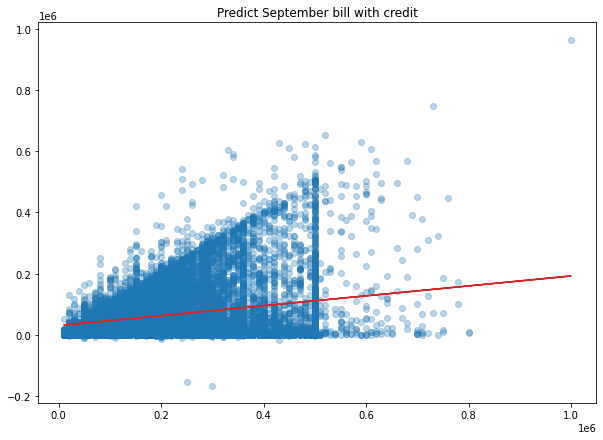

In [96]:
interact(pred_and_plot, col=Dropdown(options=defaults.columns));

Add and remove cells below as needed, but *make sure you define `my_labels`*. We have provided code for you to create your `X` array; just fill in the `...` in `my_labels` with your columns and use the space at the bottom to work on your model. Good luck!

In [103]:
# BEGIN SOLUTION NO PROMPT
my_labels = ['bill_aug05','bill_jun05','bill_may05','bill_apr05','paid_sep05']

my_X = defaults[my_labels]

my_model = sm.OLS(Y, sm.add_constant(my_X))
my_result = my_model.fit()
my_Y_hat = my_result.fittedvalues
rmse(Y, my_Y_hat)
# END SOLUTION
""" # BEGIN PROMPT
my_labels = [...]

my_X = defaults[my_labels]

my_model = ...
my_result = ...
my_Y_hat = ...
rmse(...)
"""; # END PROMPT

In [104]:
grader.check("q3")

q3 results: All test cases passed!

## Part 4: Reflection

In this section of the assignment, you will answer some conceptual questions about the choices you made in creating your model in Part 3. **This section heavily influences your grade, as we are looking to ensure that you are using econometric intuition while modeling. Please answer thoughtfully and, as always, *show us the numbers*.**

<!-- BEGIN QUESTION -->

**Question 4.1:** Explain one choice you made in selecting features while modeling in Part 3 and why you made it. (Your explanation should take at least a few sentences, and should justify your choice mathematically (i.e. with numerical evidence).)

_Type your answer here, replacing this text._

<div class="alert alert-danger">
    
<strong>SOLUTION:</strong> You should describe a choice you made and give mathematical justifications for why you made it. For example, I replace feature A with feature B because A's correlation with $y$ was &lt;a number&gt; but B's was &lt;a number&gt;, and this lowered the RMSE from &lt;a number&gt; to &lt;a number&gt;. Basically, show me the numbers.

</div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 4.2:** Use your `pred_and_plot` function in the cell below to generate a visualization that helped you choose a feature in Part 3.

RMSE: 43919.38150


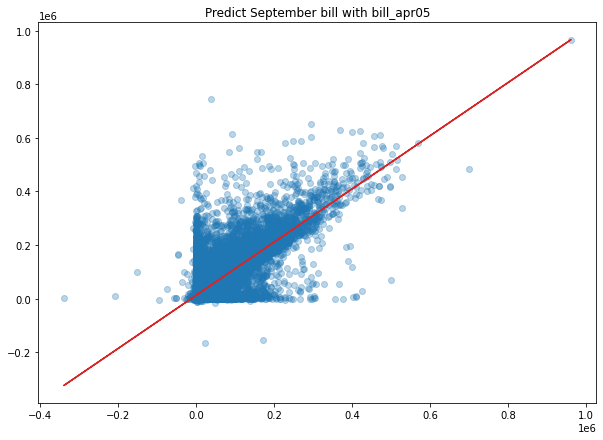

In [105]:
pred_and_plot("bill_apr05") # SOLUTION

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 4.3:** Choose a column you regressed on. Report its coefficient, $t$ statistic, and 95% CI. Interpret the coefficient's value. Is the variable likely significant? Explain.

_Type your answer here, replacing this text._

<div class="alert alert-danger">

<strong>SOLUTION:</strong> Full points with reporting all values and explanation using $t$ statistic and/or 95% CI.
    
</div>

<!-- END QUESTION -->

---

### References

* Data from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [107]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q0_1 results: All test cases passed!

    q0_2 results: All test cases passed!

    q1_1 results: All test cases passed!

    q1_2 results: All test cases passed!

    q1_3 results: All test cases passed!

    q1_5 results: All test cases passed!

    q1_7 results: All test cases passed!

    q1_8 results: All test cases passed!

    q1_10 results: All test cases passed!

    q2_1 results: All test cases passed!

    q2_3 results: All test cases passed!

    q2_4 results: All test cases passed!

    q2_5 results: All test cases passed!

    q3 results: All test cases passed!
